# Post-processing for Document Information Extraction

This notebook demonstrates how post-processing can be used at the end of model prediction. The primary purpose of the code is to combine tokens with the same label in different ways. Additionally, it is capable of parsing line-items found in supply-chain style (i.e. invoice, receipts, purchase orders etc.) documents, and the function can also invoke a template method. This code expects model predictions in either json or dataframe format and outputs final predictions in json format.

In [1]:
import os
import time
import json
import logging
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
from typing import List, Dict, Union
from IPython.display import display
from argus.processors.post_processors.utils.post_process import post_process_predictions

log = logging.getLogger()
log.setLevel(logging.INFO)
logging.info("Starting post-processing")

INFO:root:Starting post-processing


In [2]:
%%script false --no-raise-error

# post-processing function interface


def post_process_predictions(
        model_preds: Union[Dict[str, Dict[str, Dict[str, Dict[str, str]]]], pd.DataFrame],
        top_n_preds: Union[Dict[str, Union[List[float], str]], List[str]],
        token_merge_type: str = 'MIXED_MERGE',
        token_merge_xdist_regular: float = 1.0,
        label_merge_x_regular: str or None = None,
        token_merge_xydist_regular: float = 1.0,
        label_merge_xy_regular: str or None = None,
        token_merge_xdist_wide: float = 1.5,
        label_merge_x_wide: str or None = None,
        output_labels: str = 'INCLUDE_O',
        parse_line_items: bool = False,
        line_item_completeness: float = 0.6,
        try_templates: bool = False,
        templates_dict_dir: str = '',
        templates_input_dir: str = './',
        use_camelot_tables: bool = False,
        images_dir_camelot: str = '',
        verbose: bool = False
) -> Dict[str, pd.DataFrame]:
    """
    Post-processes the model predictions for Document Information Extraction

    Parameters:
    -----------
    model_preds: pandas DataFrame
        A DataFrame containing the model predictions, with columns for the document ID, page ID, coordinates,
        text content, label, and OCR confidence.
    top_n_preds: list of str
        A list of the predicted label names for the model.
    token_merge_type: str, optional (default='MIXED_MERGE')
        The type of token merging to use, either 'MIXED_MERGE' or 'NO_MERGE'.
    token_merge_xdist_regular: float, optional (default=1.0)
        The distance threshold for merging tokens on the x-axis, between 0.0 and 1.0. Distance unit is the mean height of the characters in a page.
    label_merge_x_regular: str or None, optional (default=None)
        The label names to merge on the x-axis, either 'ALL' or a string of labels separated by '|'.
    token_merge_xydist_regular: float, optional (default=1.0)
        The distance threshold for merging tokens on the x- and y-axes, between 0.0 and 1.0.
    label_merge_xy_regular: str or None, optional (default=None)
        The label names to merge on the x- and y-axes, either 'ALL' or a string of labels separated by '|'.
    token_merge_xdist_wide: float, optional (default=1.5)
        The distance threshold for wide token merging on the x-axis, between 1.0 and 10.0.
    label_merge_x_wide: str or None, optional (default=None)
        The label names to merge for wide token merging on the x-axis, either 'ALL' or a string of labels separated by '|'.
    output_labels: str or list, optional (default='INCLUDE_O')
        The type of output labels to include. Options are 'INCLUDE_O' (include all labels), 'EXCLUDE_O' (exclude "O" labels),
        or a list of label names to include.
    parse_line_items: bool, optional (default=False)
        Whether to parse line items from the input data.
    line_item_completeness: float, optional (default=0.6)
        The completeness threshold for parsing line items, between 0.0 and 1.0.
    try_templates: bool, optional (default=False)
        Whether to try extracting data using templates.
    templates_dict_dir: str, optional (default='')
        The directory path to the template configuration files.
    templates_input_dir: str, optional (default='./')
        The directory path to the input files for templates.
    use_camelot_tables: bool, optional (default=False)
        Whether to use Camelot tables for extracting line items.
    images_dir_camelot: str, optional (default='')
        The directory path to the images for Camelot tables.

    Returns:
    --------
    dict
        A dictionary containing the processed data for each document, with document IDs as keys
    """

## ID card example
Let's use an ID card example. We will use raw model predictions for the post-processing function

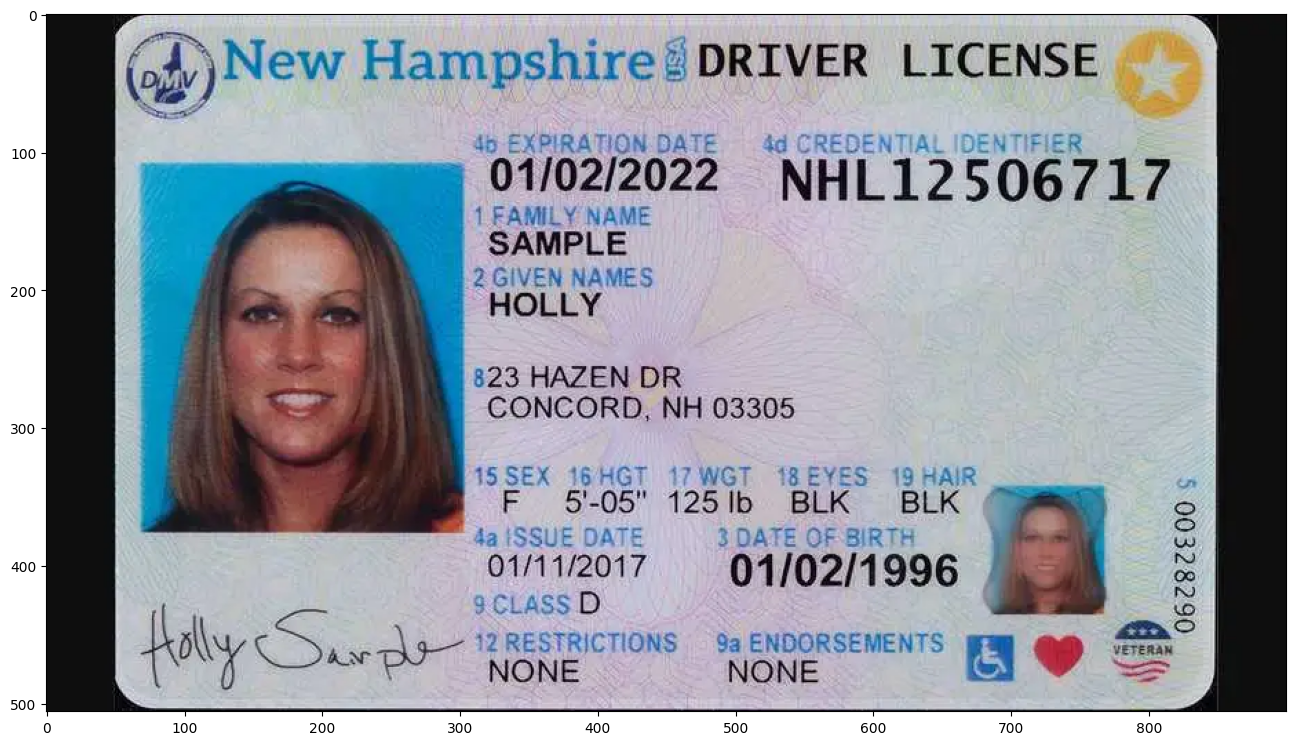

In [3]:
# Display the image
img_color = cv2.imread(r'data_post_process/DL/DL_org.png')
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,16))
plt.imshow(img)
plt.show()

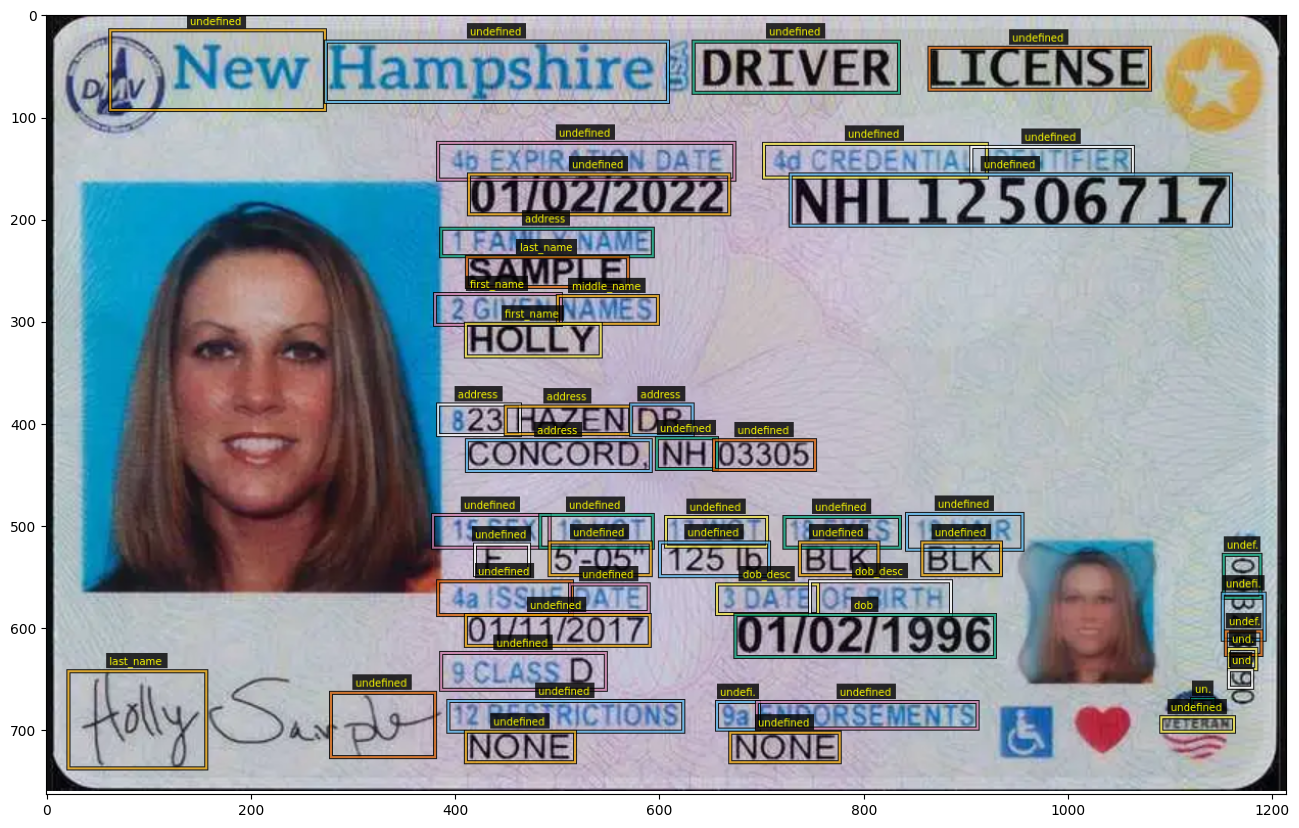

In [4]:
# Display the label image
img_color = cv2.imread(r'data_post_process/DL/DL_example.png')
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,16))
plt.imshow(img)
plt.show()

In [5]:
# load model predictions
def _load_json_if_exists(filepath, default):
    if os.path.exists(filepath):
        with open(filepath, "r") as _file:
            return json.load(_file)
    return default_dict

model_output_path = "data_post_process/DL/preds"

default_dict = {'_via_img_metadata': {}}
via_dict_path = f"{model_output_path}/preds_via/via.json"
prob_dict_path = f"{model_output_path}/eval_label/pred_llm/top_n.json"
via_predictions = _load_json_if_exists(via_dict_path, default_dict)
probabilities = _load_json_if_exists(prob_dict_path, default_dict)

In [6]:
# Try No token merging - output raw model predictions
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="NO_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular=None,
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular=None,
                                    token_merge_xdist_wide=1.5,
                                    label_merge_x_wide=None,
                                    output_labels='EXCLUDE_O',
                                    verbose=True)

# Note: No token is merged, as label_merge_* values are "None". Setting token_merge_type="NO_MERGE" would also work.


INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 536.36it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax        text       label  probability
      0 139.0 303.0 157.0 441.0 1FAMILYNAME     address     0.848884
      0 158.0 320.0 177.0 425.0      SAMPLE   last_name     0.979596
      0 182.0 299.0 202.0 381.0      2GIVEN  first_name     0.868191
      0 182.0 379.0 201.0 444.0       NAMES middle_name     0.881466
      0 201.0 319.0 222.0 407.0       HOLLY  first_name     0.617345
      0 254.0 301.0 274.0 354.0         823     address     0.995104
      0 254.0 345.0 273.0 426.0       HAZEN    

In [7]:
# Merge all same label tokens in x direction (merge in same line)
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="MIXED_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular='ALL',
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular=None,
                                    token_merge_xdist_wide=1.5,
                                    label_merge_x_wide=None,
                                    output_labels='EXCLUDE_O',
                                    verbose=True)

# Note: Set token_merge_type="MIXED_MERGE" to enable token merging. dob_desc and address tokens are merged now in x direction.

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 1218.92it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax          text       label  probability
      0 139.0 303.0 157.0 441.0   1FAMILYNAME     address     0.848884
      0 158.0 320.0 177.0 425.0        SAMPLE   last_name     0.979596
      0 182.0 299.0 202.0 381.0        2GIVEN  first_name     0.868191
      0 182.0 379.0 201.0 444.0         NAMES middle_name     0.881466
      0 201.0 319.0 222.0 407.0         HOLLY  first_name     0.617345
      0 254.0 301.0 274.0 467.0  823 HAZEN DR     address     0.995000
      0 276.0 320.0 297.0 440.0 

In [8]:
# merge only address tokens in x direction
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="MIXED_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular='address',
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular=None,
                                    token_merge_xdist_wide=1.5,
                                    label_merge_x_wide=None,
                                    output_labels='EXCLUDE_O',
                                    verbose=True)

# Note: dob_desc is not merged because it is not defined in 'label_merge_x_regular'.

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 1273.32it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax         text       label  probability
      0 139.0 303.0 157.0 441.0  1FAMILYNAME     address     0.848884
      0 158.0 320.0 177.0 425.0       SAMPLE   last_name     0.979596
      0 182.0 299.0 202.0 381.0       2GIVEN  first_name     0.868191
      0 182.0 379.0 201.0 444.0        NAMES middle_name     0.881466
      0 201.0 319.0 222.0 407.0        HOLLY  first_name     0.617345
      0 254.0 301.0 274.0 467.0 823 HAZEN DR     address     0.995000
      0 276.0 320.0 297.0 440.0     CON

In [9]:
# merge only address tokens in both x and y direction
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="MIXED_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular='address',
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular='address',
                                    token_merge_xdist_wide=1.5,
                                    label_merge_x_wide=None,
                                    output_labels='EXCLUDE_O',
                                    verbose=True)

# Note: address is merged in both x and y direction

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 1216.80it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax                  text       label  probability
      0 139.0 303.0 157.0 441.0           1FAMILYNAME     address     0.848884
      0 158.0 320.0 177.0 425.0                SAMPLE   last_name     0.979596
      0 182.0 299.0 202.0 381.0                2GIVEN  first_name     0.868191
      0 182.0 379.0 201.0 444.0                 NAMES middle_name     0.881466
      0 201.0 319.0 222.0 407.0                 HOLLY  first_name     0.617345
      0 254.0 301.0 297.0 467.0 823 HAZEN DR CONCORD,  

In [10]:
# merge all tokens in x direction and address tokens in xy direction
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="MIXED_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular='ALL',
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular='address',
                                    token_merge_xdist_wide=1.5,
                                    label_merge_x_wide=None,
                                    output_labels='EXCLUDE_O',
                                    verbose=True)

# Note: dob_desc: 3DATE OFBIRTH is merged now.

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 1220.69it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax                  text       label  probability
      0 139.0 303.0 157.0 441.0           1FAMILYNAME     address     0.848884
      0 158.0 320.0 177.0 425.0                SAMPLE   last_name     0.979596
      0 182.0 299.0 202.0 381.0                2GIVEN  first_name     0.868191
      0 182.0 379.0 201.0 444.0                 NAMES middle_name     0.881466
      0 201.0 319.0 222.0 407.0                 HOLLY  first_name     0.617345
      0 254.0 301.0 297.0 467.0 823 HAZEN DR CONCORD,  

In [11]:
# merge all tokens in x direction, name and address tokens in xy direction
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="MIXED_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular='ALL',
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular='name|address',
                                    token_merge_xdist_wide=1.5,
                                    label_merge_x_wide=None,
                                    output_labels='EXCLUDE_O',
                                    verbose=True)

# Note: first_name: 2GIVEN  HOLLY is merged now. They are vertically close.

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 1259.17it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax                  text       label  probability
      0 139.0 303.0 157.0 441.0           1FAMILYNAME     address     0.848884
      0 158.0 320.0 177.0 425.0                SAMPLE   last_name     0.979596
      0 182.0 299.0 222.0 407.0          2GIVEN HOLLY  first_name     0.743000
      0 182.0 379.0 201.0 444.0                 NAMES middle_name     0.881466
      0 254.0 301.0 297.0 467.0 823 HAZEN DR CONCORD,     address     0.995000
      0 369.0  60.0 491.0 150.0                 folly  

In [12]:
# merge all tokens in x direction, name and address tokens in xy direction. Use wide merge for 'name' tokens where they are far apart
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="MIXED_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular='ALL',
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular='name|address',
                                    token_merge_xdist_wide=20,
                                    label_merge_x_wide='name',
                                    output_labels='EXCLUDE_O',
                                    verbose=True)

# Note: last_name: SAMPLE folly is merged now though they are far apart. token_merge_xdist_wide is set to high value 20,

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 1072.44it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax                  text       label  probability
      0 139.0 303.0 157.0 441.0           1FAMILYNAME     address     0.848884
      0 158.0  60.0 491.0 425.0          SAMPLE folly   last_name     0.909000
      0 182.0 299.0 222.0 407.0          2GIVEN HOLLY  first_name     0.743000
      0 182.0 379.0 201.0 444.0                 NAMES middle_name     0.881466
      0 254.0 301.0 297.0 467.0 823 HAZEN DR CONCORD,     address     0.995000
      0 369.0 483.0 391.0 636.0         3DATE OFBIRTH  

In [13]:
# output all tokens including "O"  tokens.
result = post_process_predictions(model_preds=via_predictions,
                                    top_n_preds=probabilities,
                                    # token merging options
                                    token_merge_type="MIXED_MERGE",
                                    token_merge_xdist_regular=1.0,
                                    label_merge_x_regular='ALL',
                                    token_merge_xydist_regular=1.0,
                                    label_merge_xy_regular='address',
                                    token_merge_xdist_wide=1.5,
                                    label_merge_x_wide=None,
                                    output_labels='INCLUDE_O',
                                    verbose=True)

# Note: output_labels='INCLUDE_O', outputs all tokens including no-label tokens.

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 1202.15it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 212191868-d9ca470b-861a-48d4-81ee-691a57b43aba ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:All entities
page_id  ymin  xmin  ymax  xmax                  text       label  probability
      0  10.0  87.0  62.0 227.0                   New                 0.997411
      0  10.0 228.0  56.0 451.0            Hampshire:                 0.998314
      0  10.0 468.0  50.0 602.0                DRIVER                 0.998697
      0  10.0 622.0  48.0 766.0               LICENSE                 0.998603
      0  83.0 301.0 107.0 494.0       4EXPIRATIONDATE                 0.998237
      0  83.0 514.0 106.0 659.0         4d'CREDENTIAL  

In [14]:
# Display the full output of post-processing. It's a dictionary with keys as document ids and values as dataframes.
for item in result.values():
    display(item)

,index,doc_id,page_id,xmin,ymin,xmax,ymax,text,label,ocr_confidence,probability,O,address,dob,dob_desc,first_name,last_name,middle_name
0,0,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,87.0,10.0,227.0,62.0,New,,0.748,0.997411,0.997411,0.000266,0.000333,0.000174,0.000135,0.000331,0.000118
1,1,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,228.0,10.0,451.0,56.0,Hampshire:,,0.536,0.998314,0.998314,0.000211,0.000155,0.000101,0.000089,0.000174,0.000085
2,2,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,468.0,10.0,602.0,50.0,DRIVER,,0.996,0.998697,0.998697,0.000154,0.000109,0.000083,0.000079,0.000109,0.000060
3,3,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,622.0,10.0,766.0,48.0,LICENSE,,0.652,0.998603,0.998603,0.000180,0.000114,0.000084,0.000077,0.000123,0.000064
4,4,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,301.0,83.0,494.0,107.0,4EXPIRATIONDATE,,0.599,0.998237,0.998237,0.000141,0.000207,0.000155,0.000095,0.000187,0.000094
5,5,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,514.0,83.0,659.0,106.0,4d'CREDENTIAL,,0.578,0.997465,0.997465,0.000259,0.000295,0.000371,0.000143,0.000301,0.000115
6,6,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,649.0,83.0,754.0,104.0,IDENTIFIER,,0.963,0.998353,0.998353,0.000159,0.000127,0.000221,0.000073,0.000137,0.000083
7,7,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,321.0,104.0,491.0,130.0,01/02/2022,,0.995,0.995016,0.995016,0.000340,0.002100,0.000295,0.000178,0.000233,0.000167
8,8,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,531.0,104.0,818.0,137.0,NHL12506717,,0.999,0.998337,0.998337,0.000172,0.000268,0.000123,0.000076,0.000119,0.000089
9,9,212191868-d9ca470b-861a-48d4-81ee-691a57b43aba,0,303.0,139.0,441.0,157.0,1FAMILYNAME,address,0.7,0.848884,0.014926,0.848884,0.004115,0.002574,0.026100,0.069153,0.011187


## A sample post-processing script for general documents. It can be used as a reference for your own post-processing script.

In [15]:
%%script false --no-raise-error

# "Generic" post-processing script that only merges same line and same label tokens that are neighbours and outputs a json file.

import uuid
import pandas as pd
from typing import List

from argus.processors.post_processors.utils import post_process as pp
from h2o_docai_scorer.post_processors import BasePostProcessor, GenericEntity


class PostProcessor(BasePostProcessor):

    def client_resolution(self):
        return None

    def argus_resolution(self):
        return self.ARGUS_DPI

    def get_entities(self) -> List[GenericEntity]:
        if not self.has_labelling_model:
            return []

        docs = pp.post_process_predictions(model_preds=self.label_via_predictions,
                                   top_n_preds=self.label_top_n,
                                   token_merge_type="MIXED_MERGE",
                                   token_merge_xdist_regular=1.0,
                                   label_merge_x_regular='ALL',
                                   token_merge_xydist_regular=1.0,
                                   label_merge_xy_regular=None,
                                   token_merge_xdist_wide=1.5,
                                   label_merge_x_wide=None,
                                   output_labels='EXCLUDE_O',
                                   verbose=False)


        for doc in docs:
            docs[doc]['id'] = docs[doc]['label'].apply(lambda row: str(uuid.uuid4()))

        if hasattr(self.extra_params, 'labelingThreshold'):
            labeling_threshold = self.extra_params["labelingThreshold"]
        else:
            labeling_threshold = 0.5  # default labeling threshold

        df_list = []
        # only one array - assuming there will be only one document provided
        for doc in docs:
            predictions = docs[doc]
            predictions_filtered = []
            for label in self.label_top_n['class_names']:
                pred_df = predictions[predictions.label == label]
                pred_df = pred_df[pred_df['probability'] > labeling_threshold]
                predictions_filtered.append(pred_df)
            predictions_filtered = pd.concat(predictions_filtered)

            for idx, row in predictions_filtered.iterrows():
                df_list.append(self.get_entity(row))
        return df_list

    def get_entity(self, filtered_row) -> GenericEntity:
        filtered_label = self.remove_non_ascii(filtered_row['label'])
        filtered_text = self.remove_non_ascii(filtered_row['text'])
        data_bundle: GenericEntity = {
            'pageIndex': filtered_row['page_id'],
            'text': filtered_text,
            'label': filtered_label,
            'labelConfidence': round(filtered_row['probability'], 3),
            'ocrConfidence': filtered_row['ocr_confidence'],
            'xmin': (filtered_row['xmin']),
            'ymin': (filtered_row['ymin']),
            'xmax': (filtered_row['xmax']),
            'ymax': (filtered_row['ymax']),
            'entityId': filtered_row['id']
        }

        return data_bundle


## Supply-chain use case

Let's try a supply-chain use case where line-items are also needed to be extracted. In post-processing function, we can define if line-items needs to be parsed from the document or not. Currently, only supply-chain like documents are supported. Line-items from other types of documents (i.e. medical) are not supported yet.

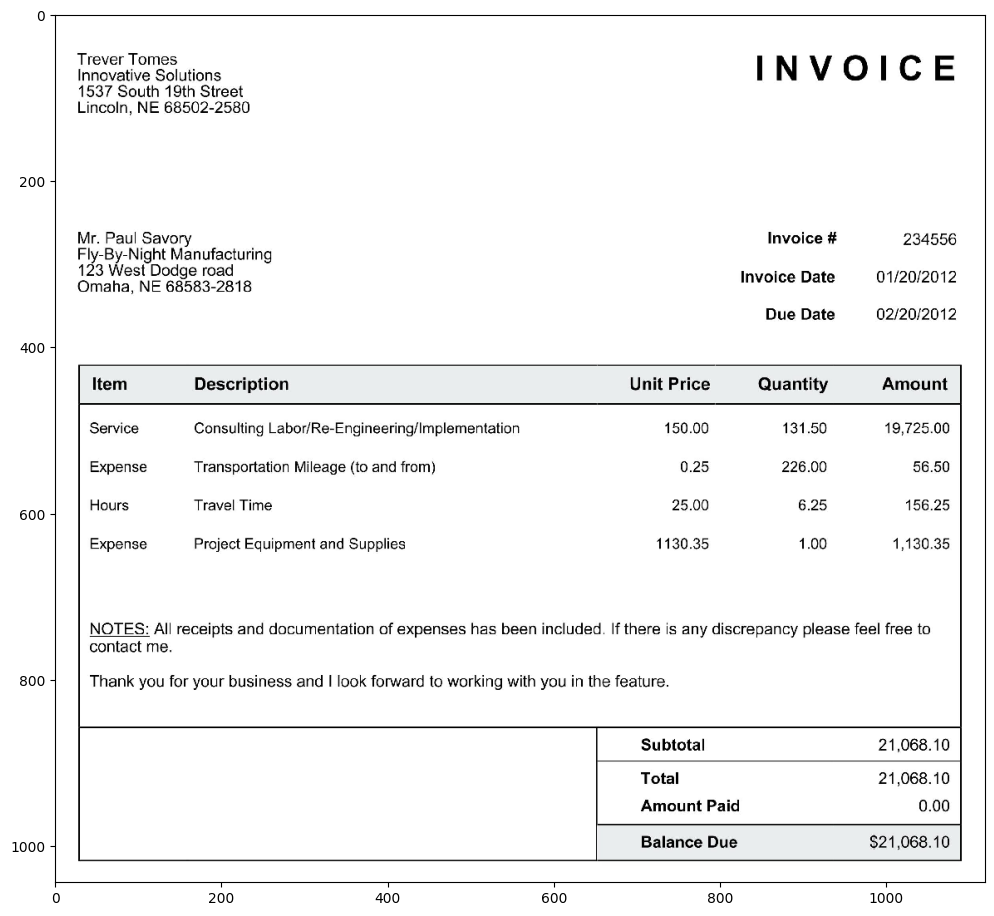

In [16]:
# show the original image
img_color = cv2.imread(r'data_post_process/invoice/invoice_org.png')
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

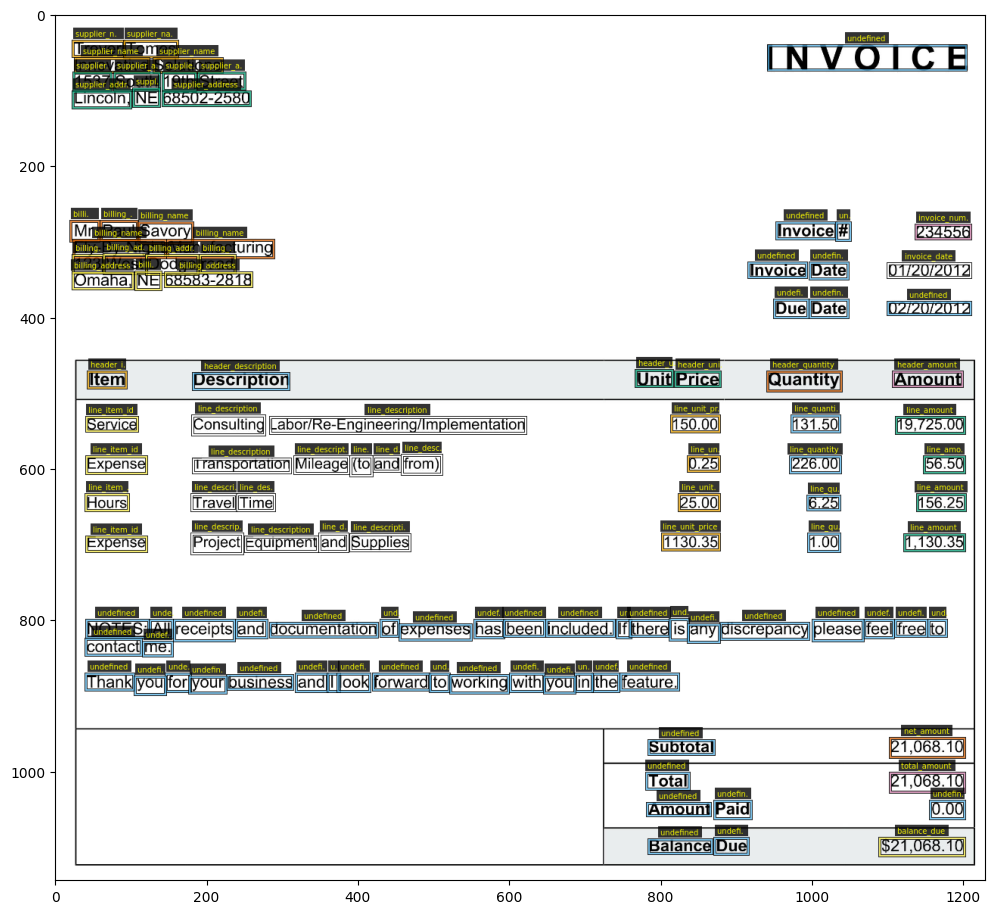

In [17]:
# Show the model predictions
img_color = cv2.imread(r'data_post_process/invoice/invoice_label.png')
img = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

In [18]:
# load the model predictions
model_output_path = "data_post_process/invoice/preds"

default_dict = {'_via_img_metadata': {}}
via_dict_path = f"{model_output_path}/preds_via/via.json"
prob_dict_path = f"{model_output_path}/eval/pred_llm/top_n.json"
via_predictions = _load_json_if_exists(via_dict_path, default_dict)
probabilities = _load_json_if_exists(prob_dict_path, default_dict)


## Assumptions for token merging:
- We want to merge some tokens only in x-direction (i.e. line_description). Merging "line_description" in x-y direction will cause merging of tokens that are not in the same line. Also name and address tokens should be merged in x-y direction. But before merging to y-direction, we need to merge them in x-direction first. So we set `label_merge_x_regular='name|address|description'`
- We want to merge some tokens in x-y direction (i.e. name, address). Therefore we set `label_merge_xy_regular="name|address"` to merge them in y direction also.
- We want to merge some tokens in x direction that are neighbours but not very close, For example, phone number may appear like "+1 333  3333  3333". We may want to merge these tokens together even they are a few whitespaces apart (i.e. phone, fax, total, net, due, date, number, invoice, po, order). Therefore we set: `label_merge_x_wide='phone|fax|total|net|due|date|number|invoice|po|order'`
- We don't want to merge some line item money tokens (i.e. price, quantity, amount, unit etc.). Sometimes they are very close to each other, and we don't want to merge them. So we did not include them anywhere.

Note that, label strings can be a subset of the actual label name. For example, if we want to merge all labels that start with **"name"**, we can set `label_merge_x_regular='name|address|description'`. This will merge all same class labels that matches the pattern **"name"** (i.e. name, name_first, name_last, name_middle, name_prefix, name_suffix, name_title, etc.). If we only need to merge the **"middle_name"** tokens", the string should be: `'middle_name|address|description'`. This is useful for writing less code, and it's a regex pattern.

In [19]:
# Display post-processing results

result = post_process_predictions(model_preds=via_predictions,
                                        top_n_preds=probabilities,
                                        # token merging options
                                        token_merge_type="MIXED_MERGE",
                                        token_merge_xdist_regular=1.0,
                                        label_merge_x_regular='name|address|description',
                                        token_merge_xydist_regular=1.0,
                                        label_merge_xy_regular="name|address",
                                        token_merge_xdist_wide=1.5,
                                        label_merge_x_wide='phone|fax|total|net|due|date|number|invoice|po|order',
                                        output_labels='EXCLUDE_O',
                                        # line-item parsing options
                                        parse_line_items=True,
                                        line_item_completeness=0.6,
                                        # template options
                                        try_templates=False,
                                        templates_dict_dir="",
                                        templates_input_dir="./",
                                        use_camelot_tables=False,
                                        images_dir_camelot="",
                                        verbose=False)

INFO:argus.processors.post_processors.utils.post_process:converting via json to dataframe (page by page)..
100%|██████████| 1/1 [00:00<00:00, 337.46it/s]
INFO:argus.processors.post_processors.utils.post_process:

---------- Processing document 0/1 : 006 ----------
INFO:argus.processors.post_processors.utils.post_process:   *** Results using ML method ***
INFO:argus.processors.post_processors.utils.post_process:Line items
page_id  line line_amount                     line_description line_item_id line_quantity line_unit_price
      0     1   19,725.00 Transportation Mileage (to and from)      Service        131.50          150.00
      0     2       56.50                          Travel Time      Expense        226.00            0.25
      0     3      156.25       Project Equipment and Supplies        Hours          6.25           25.00
      0     4    1,130.35               and Equipment Supplies      Expense          1.00         1130.35
INFO:argus.processors.post_processors.utils.p

In [20]:
# Display the full output of post-processing. It's a dictionary with keys as document ids and values as dataframes.
for item in result.values():
    display(item)

,index,doc_id,page_id,ymin,xmin,ymax,xmax,text,label,line,table_id,probability,ocr_confidence
0,0,006,0,145.0,148.0,221.0,515.0,Trever Tomes Innovative Solutions,supplier_name,,,1.000000,0.0
1,1,006,0,224.0,148.0,310.0,586.0,"1537 South 19th Street Lincoln, NE 68502-2580",supplier_address,,,1.000000,0.0
2,2,006,0,591.0,143.0,680.0,643.0,Mr. Paul Savory Fly-By-Night Manufacturing,billing_name,,,1.000000,0.0
3,3,006,0,591.0,2231.0,634.0,2366.0,234556,invoice_number,,,0.999621,0.0
4,4,006,0,673.0,148.0,759.0,589.0,"123 West Dodge road Omaha, NE 68583-2818",billing_address,,,1.000000,0.0
5,5,006,0,693.0,2162.0,729.0,2366.0,01/20/2012,invoice_date,,,0.999455,0.0
6,6,006,0,960.0,186.0,1003.0,280.0,Item,header_item_id,,,0.999424,0.0
7,7,006,0,960.0,446.0,1006.0,681.0,Description,header_description,,,0.999798,0.0
8,8,006,0,960.0,1540.0,1000.0,1629.0,Unit,header_unit_price,,,0.999785,0.0
9,9,006,0,960.0,1637.0,1000.0,1747.0,Price,header_unit_price,,,0.999783,0.0


## A sample post-processing script for supply-chain documents.

In [21]:
%%script false --no-raise-error

# Sample post-processing script for supply-chain documents.

import uuid
import pandas as pd
from typing import List
from argus.processors.post_processors.utils import post_process as pp
from h2o_docai_scorer.post_processors import BasePostProcessor, BaseEntity


class SupplyChainEntity(BaseEntity):
    text: str
    label: str
    labelConfidence: float
    ocrConfidence: float
    xmin: int
    xmax: int
    ymin: int
    ymax: int
    entityId: str
    lineId: int


class PostProcessor(BasePostProcessor):

    def client_resolution(self):
        return None

    def argus_resolution(self):
        return self.ARGUS_DPI

    def get_entities(self) -> List[SupplyChainEntity]:
        if not self.has_labelling_model:
            return []

        merging_results = pp.post_process_predictions(model_preds=via_predictions,
                                        top_n_preds=probabilities,
                                        # token merging options
                                        token_merge_type="MIXED_MERGE",
                                        token_merge_xdist_regular=1.0,
                                        label_merge_x_regular='name|address|description',
                                        token_merge_xydist_regular=1.0,
                                        label_merge_xy_regular="name|address",
                                        token_merge_xdist_wide=1.5,
                                        label_merge_x_wide='phone|fax|total|net|due|date|number|invoice|po|order',
                                        output_labels='EXCLUDE_O',
                                        # line-item parsing options
                                        parse_line_items=True,
                                        line_item_completeness=0.6,
                                        # template options
                                        try_templates=False,
                                        templates_dict_dir="",
                                        templates_input_dir="./",
                                        use_camelot_tables=False,
                                        images_dir_camelot="",
                                        verbose=False)

        for doc in merging_results:
            merging_results[doc]['id'] = merging_results[doc]['label'].apply(lambda row: str(uuid.uuid4()))

        if hasattr(self.extra_params, 'labelingThreshold'):
            labeling_threshold = self.extra_params["labelingThreshold"]
        else:
            labeling_threshold = 0.5  # default labeling threshold

        df_list = []
        # only one array - assuming there will be only one document provided
        for doc in merging_results:
            predictions = merging_results[doc]
            predictions_filtered = []
            for label in self.label_top_n['class_names']:
                pred_df = predictions[predictions.label == label]
                pred_df = pred_df[pred_df['probability'] > labeling_threshold]
                predictions_filtered.append(pred_df)
            predictions_filtered = pd.concat(predictions_filtered)

            for idx, row in predictions_filtered.iterrows():
                df_list.append(self.get_entity(row))
        return df_list

    def get_entity(self, filtered_row) -> SupplyChainEntity:
        filtered_label = self.remove_non_ascii(filtered_row['label'])
        filtered_text = self.remove_non_ascii(filtered_row['text'])
        data_bundle: SupplyChainEntity = {
            'pageIndex': filtered_row['page_id'],
            'text': filtered_text,
            'label': filtered_label,
            'labelConfidence': round(filtered_row['probability'], 3),
            'ocrConfidence': filtered_row['ocr_confidence'],
            'lineId': filtered_row['line'],
            'xmin': (filtered_row['xmin']),
            'ymin': (filtered_row['ymin']),
            'xmax': (filtered_row['xmax']),
            'ymax': (filtered_row['ymax']),
            'entityId': filtered_row['id']
        }

        return data_bundle
